In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Cargar los datos
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
X_valid = pd.read_csv('../data/processed/X_valid.csv')
y_valid = pd.read_csv('../data/processed/y_valid.csv')

<Axes: >

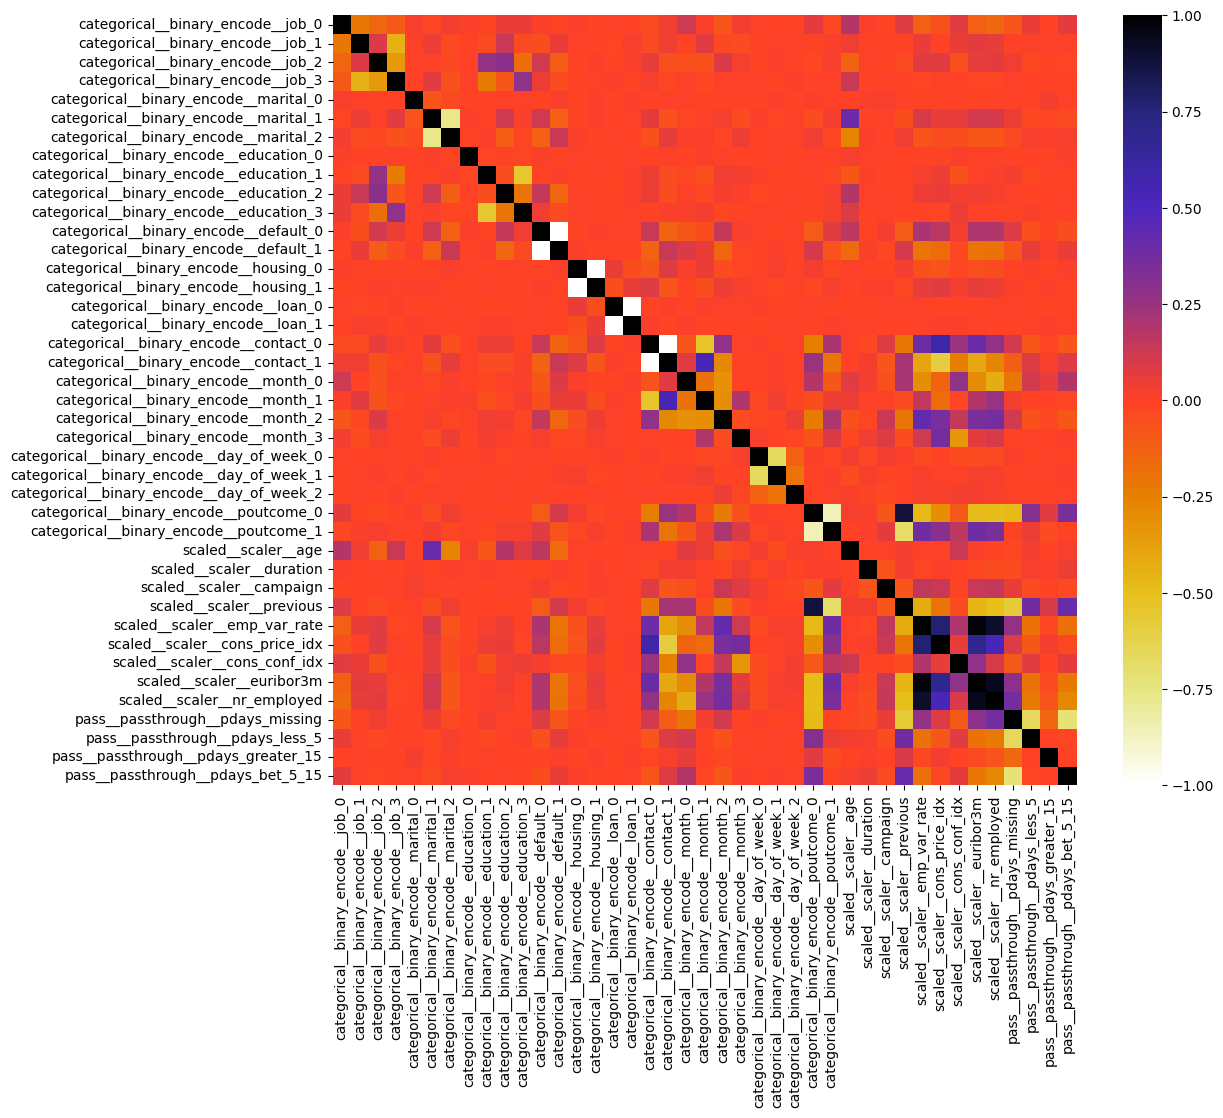

In [3]:

plt.figure(figsize=(12,10))
cor = X_train.corr()
sns.heatmap(cor, cmap=plt.cm.CMRmap_r)

In [4]:
def correlation(X, threshold):
    col_corr = set()
    corr_matrix = X.corr()
    for i in range(len(corr_matrix)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [5]:
corr_features = correlation(X_train, 0.9)
len(set(corr_features))

6

In [6]:
X_train.drop(corr_features, axis=1)
X_valid.drop(corr_features, axis=1)

,categorical__binary_encode__job_0,categorical__binary_encode__job_1,categorical__binary_encode__job_2,categorical__binary_encode__job_3,categorical__binary_encode__marital_0,categorical__binary_encode__marital_1,categorical__binary_encode__marital_2,categorical__binary_encode__education_0,categorical__binary_encode__education_1,categorical__binary_encode__education_2,...,scaled__scaler__duration,scaled__scaler__campaign,scaled__scaler__previous,scaled__scaler__emp_var_rate,scaled__scaler__cons_price_idx,scaled__scaler__cons_conf_idx,pass__passthrough__pdays_missing,pass__passthrough__pdays_less_5,pass__passthrough__pdays_greater_15,pass__passthrough__pdays_bet_5_15
0,0,0,0,1,0,0,1,0,0,0,...,-0.470046,-0.5,1.0,-0.90625,-0.931447,-0.698413,1,0,0,0
1,0,0,1,0,0,1,0,0,0,1,...,1.359447,0.5,0.0,-0.90625,-0.931447,-0.698413,1,0,0,0
2,0,0,1,1,0,0,1,0,0,0,...,6.834101,0.5,0.0,-0.90625,-0.733406,-0.841270,1,0,0,0
3,0,0,0,1,0,0,1,0,0,0,...,-0.101382,1.0,0.0,0.09375,0.183896,-0.142857,1,0,0,0
4,0,1,0,0,0,1,0,0,0,1,...,0.073733,0.0,0.0,0.00000,0.266594,0.857143,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8234,0,0,1,1,0,1,1,0,0,0,...,-0.225806,0.0,0.0,0.09375,0.779108,0.000000,1,0,0,0
8235,0,0,1,0,0,1,1,0,1,1,...,0.562212,0.0,0.0,0.00000,0.266594,0.857143,1,0,0,0
8236,0,0,0,1,0,1,0,0,1,1,...,1.516129,-0.5,0.0,0.00000,0.266594,0.857143,1,0,0,0
8237,1,0,0,1,0,1,0,0,1,0,...,-0.304147,-0.5,0.0,-0.90625,-0.985854,-1.301587,1,0,0,0


In [7]:
# Función para evaluar el modelo
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    # y_pred_proba = model.predict_proba(X)[:, 1]
    
    f1 = f1_score(y, y_pred)
    f1_weighted = f1_score(y, y_pred, average='weighted')
    # auc_roc = roc_auc_score(y, y_pred_proba)
    
    return {
        'F1-score': f1,
        'F1-score weighted': f1_weighted,
    }

In [8]:
# Diccionario para almacenar los resultados
results = {}

In [9]:
# Lista de modelos a explorar
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'SVM': SVC(class_weight='balanced', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]), random_state=42),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42)
}

In [10]:
# Explorar modelos
for name, model in models.items():
    print(f"Evaluando {name}...")
    model.fit(X_train, y_train.values.ravel())
    results[name] = evaluate_model(model, X_valid, y_valid)
    
    # Realizar validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train.values.ravel(), cv=5, scoring='f1')
    results[name]['CV F1-score'] = cv_scores.mean()

Evaluando Logistic Regression...
Evaluando SVM...
Evaluando Random Forest...
Evaluando XGBoost...
Evaluando LightGBM...
[LightGBM] [Info] Number of positive: 2784, number of negative: 21928
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 24712, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 2227, number of negative: 17542
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6

In [11]:
# Imprimir resultados
for model, metrics in results.items():
    print(f"\nResultados para {model}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Crear un DataFrame con los resultados para facilitar el ranking
df_results = pd.DataFrame(results).T

# Calcular un puntaje compuesto (promedio de las métricas)
df_results['Composite Score'] = df_results[['F1-score', 'F1-score weighted']].mean(axis=1)


Resultados para Logistic Regression:
F1-score: 0.5583
F1-score weighted: 0.8751
CV F1-score: 0.5764

Resultados para SVM:
F1-score: 0.4433
F1-score weighted: 0.7988
CV F1-score: 0.5780

Resultados para Random Forest:
F1-score: 0.4146
F1-score weighted: 0.8891
CV F1-score: 0.4815

Resultados para XGBoost:
F1-score: 0.5266
F1-score weighted: 0.8967
CV F1-score: 0.5708

Resultados para LightGBM:
F1-score: 0.5899
F1-score weighted: 0.8786
CV F1-score: 0.6243


In [12]:
# Ordenar los modelos basados en el puntaje compuesto
ranked_models = df_results.sort_values('Composite Score', ascending=False)
print("\nRanking de los 3 mejores algoritmos:")
print(ranked_models[['F1-score', 'F1-score weighted']].head(3))

# Encontrar el mejor modelo basado en el puntaje compuesto
best_model = ranked_models.index[0]
print(f"\nEl mejor modelo basado en el puntaje compuesto es: {best_model}")


Ranking de los 3 mejores algoritmos:
                     F1-score  F1-score weighted
LightGBM             0.589862           0.878628
Logistic Regression  0.558280           0.875096
XGBoost              0.526556           0.896723

El mejor modelo basado en el puntaje compuesto es: LightGBM
